In [1]:
from src.DataFolder import DataFolder
from src.NeuralSignal import NeuralSignal
from src.runtime_logger import logger_setup

import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data_path = "/home/miranjo/phasic_tonic/data/processed"
config_path = "/home/miranjo/phasic_tonic/configs/test.yaml"

## Setup

### Load the config file

In [2]:
with open(config_path, 'r') as f:
    args = yaml.safe_load(f)

fs                  = args.pop("fs")
f_theta             = (args.pop("f_theta_lower"), args.pop("f_theta_upper"))
f_lowpass           = args.pop("f_lowpass")
lowpass_length      = args.pop("lowpass_length")
bandpass_length     = args.pop("bandpass_length")
threshold_bycycle   = args.pop("threshold_bycycle")
threshold_episode   = args.pop("threshold_episode")

# Start logger
logger = logger_setup()

Runtime log started.
Logging to file runtime.log


### Load the dataset

In [3]:
remFolder = DataFolder(data_path)

Initializing a DataFolder.
DataFolder in /home/miranjo/phasic_tonic/data/processed contains 102 files.


### Utilities

In [6]:
def normalize(ndarray):
    return (ndarray - ndarray.mean())/np.std(ndarray)

def calculate_freq_bin(target, n_bins):
    spectrum_low, spectrum_high = 1, 45
    f_bin = n_bins/(spectrum_high-spectrum_low)
    return np.floor((target - 1)*f_bin + 1)

# Analysis

## Sample

Initializing NeuralSignal.
Metadata: Rat4_SD9_HomeCage_VEH_posttrial3
STARTED: Segmenting the signal into phasic and tonic episodes.
Found 19 phasic cycles in the signal
Found 894 tonic cycles in the signal
COMPLETED: Segmenting the signal into phasic and tonic episodes.


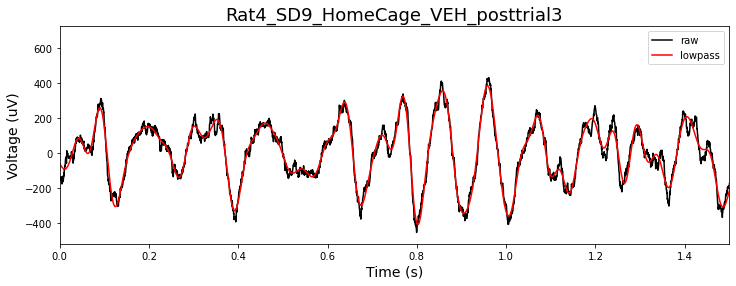

In [7]:
remData = remFolder[3]
arrays = remData["data"]
metadata = remData["metadata"]

sig = NeuralSignal(arrays[0], fs)
sig.set_metadata(metadata)
sig.filter("lowpass", f_range=f_lowpass, n_seconds=lowpass_length)
sig.plot(xlim=(0,1.5), figsize=(12,4))
sig.segment(f_theta, threshold_episode, threshold_bycycle)

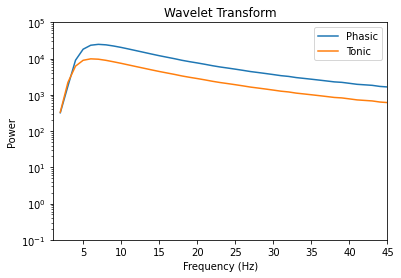

In [8]:
# Import spectral power functions
from neurodsp.spectral import compute_spectrum_wavelet, compute_spectrum

# Compute frequency statistics
n_bins = 44
spectrum_ph = np.zeros((len(sig.phasic), n_bins))
spectrum_to = np.zeros((len(sig.tonic), n_bins))
freq = np.arange(2, 46)

n_cycles = 1

for i, tonic in enumerate(sig.get_tonic()):
    if len(tonic) < sig.fs/2:
        print("Tonic period", i, "has a length of ", len(tonic), "skipping.")
        break
    #elif len(tonic) < n_cycles * sig.sampling_rate:
    #    n_cycles = int(2 * len(tonic) / sig.sampling_rate)
    
    #print(len(tonic), n_cycles)
    f, spectrum = compute_spectrum_wavelet(tonic, sig.fs, freqs=[2, 45], n_cycles=n_cycles)
    
    #f, spectrum = compute_spectrum(tonic, sig.sampling_rate, method='welch', avg_type='mean')
    spectrum_to[i, :] = spectrum

for i, phasic in enumerate(sig.get_phasic()):
    if len(phasic) < sig.fs/2:
        print("Phasic period", i, "has a length of ", len(phasic), "skipping.")
        break
    #elif len(phasic) < n_cycles * sig.sampling_rate:
    #    n_cycles = int(2 * len(phasic) / sig.sampling_rate)
    
    #print(len(phasic), n_cycles)
    f, spectrum = compute_spectrum_wavelet(phasic, sig.fs, freqs=[2, 45], n_cycles=n_cycles)
    
    #f, spectrum = compute_spectrum(phasic, sig.sampling_rate, method='welch', avg_type='mean')
    spectrum_ph[i, :] = spectrum

spectrum = np.vstack([np.mean(spectrum_ph, axis=0), 
                      np.mean(spectrum_to, axis=0)])

plt.plot(freq, spectrum[0])
plt.plot(freq, spectrum[1])

plt.xticks(np.arange(10)*5)

plt.yscale('log')

plt.ylim(10**-1, 10**5)
plt.xlim(1, 45)

plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')

plt.title('Wavelet Transform')
plt.legend(['Phasic', 'Tonic'])

## Dataset

In [9]:
spectrum_phasic = []
spectrum_tonic = []

# Compute frequency statistics
n_bins = 44
spectrum_ph = np.zeros((len(sig.phasic), n_bins))
spectrum_to = np.zeros((len(sig.tonic), n_bins))
freq = np.arange(2, 46)

n_cycles = 7

for sample in remFolder:
    lfpREMs = sample["data"]
    
    for lfpREM in lfpREMs:
        
        if(len(lfpREM) < 2500): 
            break    #Skip when the duration is less than a second
        
        theta = NeuralSignal(lfpREM, fs)
        theta.filter('lowpass', f_range=f_lowpass, n_seconds=lowpass_length)
        theta.segment(f_range=f_theta, threshold_episode=threshold_episode, threshold_bycycle=threshold_bycycle)

        theta_tonic = np.zeros((len(theta.tonic), n_bins))
        theta_phasic = np.zeros((len(theta.phasic), n_bins))

        for i, tonic in enumerate(theta.get_tonic()):
            f, spectrum = compute_spectrum_wavelet(tonic, sig.fs, freqs=[2, 45])
            theta_tonic[i, :] = spectrum
            
        for i, phasic in enumerate(theta.get_phasic()):
            if len(phasic) < sig.fs/2:
                logger.warn("Phasic period {0} has a length of {1} skipping.".format(i, len(tonic)))
                break
            elif len(phasic) < n_cycles * sig.fs:
                n_cycles = int(2 * len(phasic) / sig.fs)
            logger.debug("n_cycles: {0}, phasic.shape: {1}".format(n_cycles, phasic.shape))
            f, spectrum = compute_spectrum_wavelet(phasic, sig.fs, freqs=[2, 45])
            theta_phasic[i, :] = spectrum
        
        spectrum_tonic.append(theta_tonic)
        spectrum_phasic.append(theta_phasic)

spectrum_phasic = np.vstack(spectrum_phasic)
spectrum_tonic = np.vstack(spectrum_tonic)

phasic_spectrum_mean = np.mean(spectrum_phasic, axis=0)
tonic_spectrum_mean = np.mean(spectrum_tonic, axis=0)

phasic_spectrum_std = np.std(spectrum_phasic, axis=0)
tonic_spectrum_std = np.std(spectrum_tonic, axis=0)


Initializing NeuralSignal.


STARTED: Segmenting the signal into phasic and tonic episodes.
Found 0 phasic cycles in the signal
Found 667 tonic cycles in the signal
COMPLETED: Segmenting the signal into phasic and tonic episodes.
Initializing NeuralSignal.
STARTED: Segmenting the signal into phasic and tonic episodes.
Found 0 phasic cycles in the signal
Found 849 tonic cycles in the signal
COMPLETED: Segmenting the signal into phasic and tonic episodes.
Initializing NeuralSignal.
STARTED: Segmenting the signal into phasic and tonic episodes.
Found 0 phasic cycles in the signal
Found 1154 tonic cycles in the signal
COMPLETED: Segmenting the signal into phasic and tonic episodes.
Initializing NeuralSignal.
STARTED: Segmenting the signal into phasic and tonic episodes.
Found 0 phasic cycles in the signal
Found 319 tonic cycles in the signal
COMPLETED: Segmenting the signal into phasic and tonic episodes.
Initializing NeuralSignal.
STARTED: Segmenting the signal into phasic and tonic episodes.
Found 0 phasic cycles in

ValueError: The length of the wavelet is greater than the signal. Can not proceed.

In [10]:
wavelet_len

NameError: name 'wavelet_len' is not defined

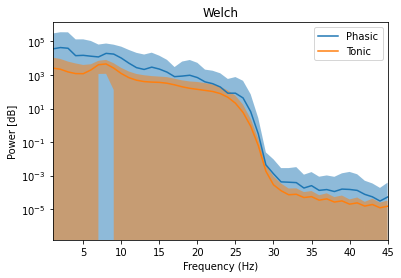

In [22]:
freq = np.arange(1, 46)
plt.plot(freq, phasic_spectrum_mean)
plt.plot(freq, tonic_spectrum_mean)

#plt.fill_between(freq, phasic_spectrum_mean - phasic_spectrum_std,
#                 phasic_spectrum_mean + phasic_spectrum_std, 
#                 alpha=0.5, label='Standard Deviation of Phasic Spectrum')
#
#plt.fill_between(freq, tonic_spectrum_mean - tonic_spectrum_std,
#                 tonic_spectrum_mean + tonic_spectrum_std, 
#                 alpha=0.5, label='Standard Deviation of Tonic Spectrum')

plt.xlim(1, 45)

plt.xlabel('Frequency (Hz)')
plt.ylabel('Power [dB]')

plt.yscale('log')

plt.title('Welch')
plt.legend(['Phasic', 'Tonic'])

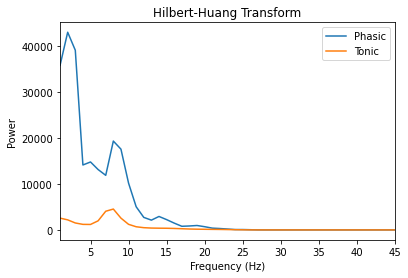

In [26]:
plt.plot(freq, phasic_spectrum_mean)
plt.plot(freq, tonic_spectrum_mean)

#plt.fill_between(freq, phasic_spectrum_mean - phasic_spectrum_std,
#                 phasic_spectrum_mean + phasic_spectrum_std, 
#                 alpha=0.5, label='Standard Deviation of Phasic Spectrum')
#
#plt.fill_between(freq, tonic_spectrum_mean - tonic_spectrum_std,
#                 tonic_spectrum_mean + tonic_spectrum_std, 
#                 alpha=0.5, label='Standard Deviation of Tonic Spectrum')

plt.xlim(1, 45)

plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')

plt.yscale('linear')

plt.title('Hilbert-Huang Transform')
plt.legend(['Phasic', 'Tonic'])

{'whiskers': [<matplotlib.lines.Line2D at 0x7fa2f3ae5960>,
 'caps': [<matplotlib.lines.Line2D at 0x7fa2f3ae5f00>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fa2f3ae5690>,
 'medians': [<matplotlib.lines.Line2D at 0x7fa2f3ae64a0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fa2f3ae6770>,
 'means': []}

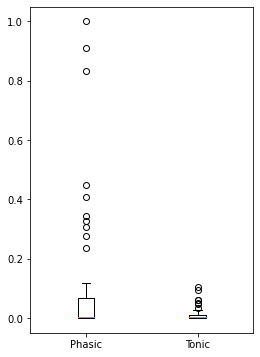

In [21]:
plt.figure(figsize=(4,6))
plt.boxplot([phasic_spectrum_mean/phasic_spectrum_mean.max(),
             tonic_spectrum_mean/phasic_spectrum_mean.max()],
            labels=["Phasic", "Tonic"])